# Applied ML Assignment 5 Part 2 - Transfer learning on Text Data


## Importing Libraries

In [1]:
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import os
import seaborn as sns
import matplotlib.pyplot as plt

## Splitting the data into train and test

In [2]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = str(self.data.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        target = self.data.sentiment[index]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [3]:
test_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/test.csv',encoding='unicode_escape');
train_df = pd.read_csv('//kaggle/input/sentiment-analysis-dataset/train.csv',encoding='latin1');

In [4]:
sentiment_category_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

train_df['sentiment'] = train_df['sentiment'].map(sentiment_category_mapping)
test_df['sentiment'] = test_df['sentiment'].map(sentiment_category_mapping)

In [5]:
unique_sentiments_train = pd.unique(train_df['sentiment'])
print("Unique sentiment categories in train dataset:", unique_sentiments_train)

unique_sentiments_test = pd.unique(test_df['sentiment'])
print("Unique sentiment categories in test dataset:", unique_sentiments_test)

Unique sentiment categories in train dataset: [1 0 2]
Unique sentiment categories in test dataset: [ 1.  2.  0. nan]


In [6]:
test_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1.0,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,96d74cb729,Shanghai is also really exciting (precisely -...,2.0,noon,21-30,Albania,2877797.0,27400.0,105.0
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0.0,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,01082688c6,happy bday!,2.0,morning,46-60,Andorra,77265.0,470.0,164.0
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2.0,noon,60-70,Angola,32866272.0,1246700.0,26.0
...,...,...,...,...,...,...,...,...,...
4810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
train_df

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,0,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,0,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,noon,60-70,Angola,32866272,1246700.0,26
...,...,...,...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,0,night,31-45,Ghana,31072940,227540.0,137
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",0,morning,46-60,Greece,10423054,128900.0,81
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,2,noon,60-70,Grenada,112523,340.0,331
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,2,night,70-100,Guatemala,17915568,107160.0,167


## Dropping NaN values

In [8]:
test_df.dropna(inplace=True)


In [9]:
nan_counts = test_df.isna().sum()
print("Number of NaN values in each column:\n", nan_counts)

Number of NaN values in each column:
 textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64


In [10]:
# Parameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
# Data loaders
train_dataset = SentimentDataset(train_df, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = SentimentDataset(test_df, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE, shuffle=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [14]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
optimizer = AdamW(model.parameters(), lr=1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
CHECKPOINT_PATH = "model_checkpoint.pt"

# Load model and optimizer state if exists
if os.path.isfile(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch no. {start_epoch+1}")
else:
    start_epoch = 0

In [17]:
def save_checkpoint(epoch, model, optimizer, filename=CHECKPOINT_PATH):
    """
    Save a checkpoint of the model and optimizer state.

    Args:
        epoch (int): Current epoch number.
        model (torch.nn.Module): Model to be saved.
        optimizer (torch.optim.Optimizer): Optimizer associated with the model.
        filename (str): Path to save the checkpoint file (default: CHECKPOINT_PATH).

    """
    # Create a dictionary to store checkpoint information
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),  # Save model state dictionary
        'optimizer_state_dict': optimizer.state_dict()  # Save optimizer state dictionary
    }

    # Save the checkpoint to the specified file path
    torch.save(checkpoint, filename)

    # Print a message indicating that the checkpoint was saved
    print(f"Checkpoint saved at epoch {epoch + 1}")


In [18]:
train_losses = []

def train(epoch):
    """
    Perform model training for a single epoch.

    Args:
        epoch (int): Current epoch number.

    """
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate over batches in the training DataLoader
    for batch_idx, data in tqdm(enumerate(train_loader, 0), desc=f"Epoch {epoch}"):
        # Move batch data to the appropriate device (GPU if available)
        ids = data['ids'].to(device)
        mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        # Forward pass: compute model predictions and loss
        outputs = model(ids, mask, token_type_ids, labels=targets)
        loss = outputs[0]

        # Print loss periodically during training
        if batch_idx % 5000 == 0:
            print(f'Batch: {batch_idx}, Loss: {loss.item()}')

        # Backward pass: compute gradients and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch and save the checkpoint
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)
    save_checkpoint(epoch, model, optimizer)


In [19]:
for i in range(5):
    train(epoch)

  0%|          | 0/3 [00:00<?, ?it/s]
Epoch 0: 0it [00:00, ?it/s]

Batch: 0, Loss: 1.1266541481018066



Epoch 0: 1it [00:01,  1.40s/it]
Epoch 0: 2it [00:02,  1.04s/it]
Epoch 0: 3it [00:02,  1.10it/s]
Epoch 0: 4it [00:03,  1.18it/s]
Epoch 0: 5it [00:04,  1.22it/s]
Epoch 0: 6it [00:05,  1.25it/s]
Epoch 0: 7it [00:05,  1.27it/s]
Epoch 0: 8it [00:06,  1.28it/s]
Epoch 0: 9it [00:07,  1.30it/s]
Epoch 0: 10it [00:08,  1.30it/s]
Epoch 0: 11it [00:09,  1.31it/s]
Epoch 0: 12it [00:09,  1.31it/s]
Epoch 0: 13it [00:10,  1.32it/s]
Epoch 0: 14it [00:11,  1.32it/s]
Epoch 0: 15it [00:12,  1.32it/s]
Epoch 0: 16it [00:12,  1.31it/s]
Epoch 0: 17it [00:13,  1.32it/s]
Epoch 0: 18it [00:14,  1.32it/s]
Epoch 0: 19it [00:15,  1.32it/s]
Epoch 0: 20it [00:15,  1.32it/s]
Epoch 0: 21it [00:16,  1.32it/s]
Epoch 0: 22it [00:17,  1.32it/s]
Epoch 0: 23it [00:18,  1.32it/s]
Epoch 0: 24it [00:18,  1.31it/s]
Epoch 0: 25it [00:19,  1.31it/s]
Epoch 0: 26it [00:20,  1.32it/s]
Epoch 0: 27it [00:21,  1.31it/s]
Epoch 0: 28it [00:21,  1.31it/s]
Epoch 0: 29it [00:22,  1.31it/s]
Epoch 0: 30it [00:23,  1.31it/s]
Epoch 0: 31it [00:

Checkpoint saved at epoch 1



Epoch 1: 0it [00:00, ?it/s]

Batch: 0, Loss: 0.4580453038215637



Epoch 1: 1it [00:00,  1.28it/s]
Epoch 1: 2it [00:01,  1.29it/s]
Epoch 1: 3it [00:02,  1.28it/s]
Epoch 1: 4it [00:03,  1.28it/s]
Epoch 1: 5it [00:03,  1.28it/s]
Epoch 1: 6it [00:04,  1.28it/s]
Epoch 1: 7it [00:05,  1.28it/s]
Epoch 1: 8it [00:06,  1.27it/s]
Epoch 1: 9it [00:07,  1.28it/s]
Epoch 1: 10it [00:07,  1.27it/s]
Epoch 1: 11it [00:08,  1.28it/s]
Epoch 1: 12it [00:09,  1.28it/s]
Epoch 1: 13it [00:10,  1.27it/s]
Epoch 1: 14it [00:10,  1.28it/s]
Epoch 1: 15it [00:11,  1.28it/s]
Epoch 1: 16it [00:12,  1.28it/s]
Epoch 1: 17it [00:13,  1.28it/s]
Epoch 1: 18it [00:14,  1.28it/s]
Epoch 1: 19it [00:14,  1.28it/s]
Epoch 1: 20it [00:15,  1.28it/s]
Epoch 1: 21it [00:16,  1.28it/s]
Epoch 1: 22it [00:17,  1.28it/s]
Epoch 1: 23it [00:17,  1.28it/s]
Epoch 1: 24it [00:18,  1.28it/s]
Epoch 1: 25it [00:19,  1.28it/s]
Epoch 1: 26it [00:20,  1.28it/s]
Epoch 1: 27it [00:21,  1.28it/s]
Epoch 1: 28it [00:21,  1.28it/s]
Epoch 1: 29it [00:22,  1.28it/s]
Epoch 1: 30it [00:23,  1.28it/s]
Epoch 1: 31it [00:

Checkpoint saved at epoch 2



Epoch 2: 0it [00:00, ?it/s]

Batch: 0, Loss: 0.6380948424339294



Epoch 2: 1it [00:00,  1.26it/s]
Epoch 2: 2it [00:01,  1.27it/s]
Epoch 2: 3it [00:02,  1.28it/s]
Epoch 2: 4it [00:03,  1.28it/s]
Epoch 2: 5it [00:03,  1.28it/s]
Epoch 2: 6it [00:04,  1.28it/s]
Epoch 2: 7it [00:05,  1.28it/s]
Epoch 2: 8it [00:06,  1.28it/s]
Epoch 2: 9it [00:07,  1.28it/s]
Epoch 2: 10it [00:07,  1.28it/s]
Epoch 2: 11it [00:08,  1.28it/s]
Epoch 2: 12it [00:09,  1.28it/s]
Epoch 2: 13it [00:10,  1.28it/s]
Epoch 2: 14it [00:10,  1.28it/s]
Epoch 2: 15it [00:11,  1.28it/s]
Epoch 2: 16it [00:12,  1.28it/s]
Epoch 2: 17it [00:13,  1.28it/s]
Epoch 2: 18it [00:14,  1.28it/s]
Epoch 2: 19it [00:14,  1.28it/s]
Epoch 2: 20it [00:15,  1.28it/s]
Epoch 2: 21it [00:16,  1.28it/s]
Epoch 2: 22it [00:17,  1.28it/s]
Epoch 2: 23it [00:17,  1.28it/s]
Epoch 2: 24it [00:18,  1.28it/s]
Epoch 2: 25it [00:19,  1.28it/s]
Epoch 2: 26it [00:20,  1.28it/s]
Epoch 2: 27it [00:21,  1.28it/s]
Epoch 2: 28it [00:21,  1.28it/s]
Epoch 2: 29it [00:22,  1.28it/s]
Epoch 2: 30it [00:23,  1.28it/s]
Epoch 2: 31it [00:

Checkpoint saved at epoch 3


In [20]:
val_losses = []
val_accuracies = []

def evaluate():
    """
    Returns:
        tuple: A tuple containing the true targets and predicted outputs.

    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    fin_targets, fin_outputs = [], []

    with torch.no_grad():
        # Iterate over batches in the validation DataLoader
        for batch_idx, data in tqdm(enumerate(test_loader, 0), desc="Evaluation"):
            # Move batch data to the appropriate device (GPU if available)
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            # Forward pass: compute model predictions and loss
            outputs = model(ids, mask, token_type_ids, labels=targets)
            logits = outputs.logits
            loss = outputs.loss
            running_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == targets)
            total_predictions += targets.size(0)

            # Collect targets and predicted outputs for analysis
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(preds.cpu().detach().numpy().tolist())

    # Calculate average loss and accuracy
    average_loss = running_loss / len(test_loader)
    accuracy = correct_predictions.double() / total_predictions

    # Store validation metrics
    val_losses.append(average_loss)
    val_accuracies.append(accuracy.item())

    return fin_targets, fin_outputs


## Classification Report

Evaluation: 111it [00:27,  3.97it/s]


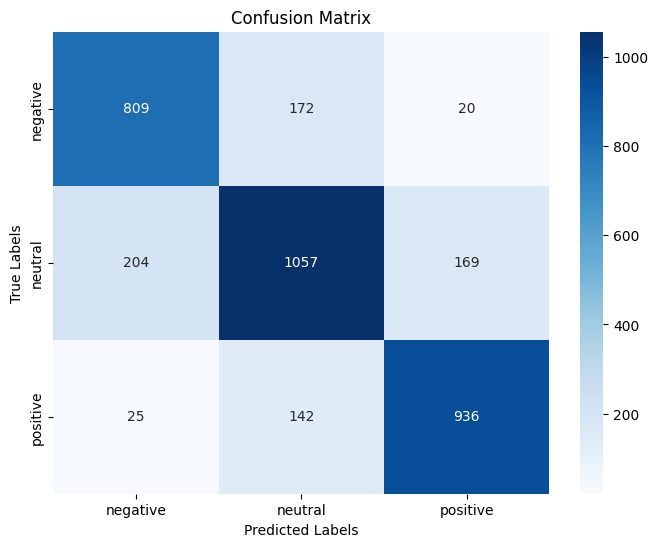

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.81      0.79      1001
     neutral       0.77      0.74      0.75      1430
    positive       0.83      0.85      0.84      1103

    accuracy                           0.79      3534
   macro avg       0.79      0.80      0.80      3534
weighted avg       0.79      0.79      0.79      3534



In [22]:
# Assuming 'targets' and 'outputs' are obtained from the evaluate function
targets, outputs = evaluate()

# Create a confusion matrix
conf_matrix = confusion_matrix(targets, outputs)

# Define target names for classification report
target_names = ['negative', 'neutral', 'positive']

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(targets, outputs, target_names=target_names))